In [ ]:
from google.colab import files
uploaded = files.upload()

Saving data.zip to data.zip


In [ ]:
!unzip -o data.zip -d .
!pip -q install librosa==0.10.1 scikit-learn==1.3.2 soundfile==0.12.1 matplotlib==3.8.0 numpy==1.23.5

Archive:  data.zip
   creating: ./data/classical/
  inflating: ./data/classical/c1.mp3  
  inflating: ./data/classical/c2.mp3  
  inflating: ./data/classical/c3.mp3  
   creating: ./data/hip hop/
  inflating: ./data/hip hop/h1.mp3   
  inflating: ./data/hip hop/h2.mp3   
  inflating: ./data/hip hop/h3.mp3   
   creating: ./data/jazz/
  inflating: ./data/jazz/j1.mp3      
  inflating: ./data/jazz/j2.mp3      
  inflating: ./data/jazz/j3.mp3      
   creating: ./data/rock/
  inflating: ./data/rock/r1.mp3      
  inflating: ./data/rock/r2.mp3      
  inflating: ./data/rock/r3.mp3      
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 80.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... erro

In [ ]:
import os, numpy as np, pandas as pd
import librosa, librosa.display
SR = 22050 #sample rate
SEGMENTS = 3
N_MFCC = 20
def extract_vector(y, sr):
  y=librosa.util.normalize(y)
  mfcc=librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC).mean(axis=1)
  chroma=librosa.feature.chroma_stft(y=y, sr=sr).mean(axis=1)
  contrast=librosa.feature.spectral_contrast(y=y, sr=sr).mean(axis=1)
  return np.concatenate([mfcc, chroma, contrast])
rows=[]
root='data'
genres=[g for g in os.listdir(root) if os.path.isdir(os.path.join(root, g))]
genres.sort()
for g in genres:
  gpath = os.path.join(root, g)
  for fname in os.listdir(gpath):
    if not fname.lower().endswith(('.mp3','.wav','.m4a','.flac','.ogg')):
      continue
    fpath=os.path.join(gpath,fname)
    try:
      y,sr=librosa.load(fpath, sr=SR, mono=True)
      L=len(y)
      seg_len=L//SEGMENTS
      for s in range(SEGMENTS):
        seg=y[s*seg_len:(s+1)*seg_len]if seg_len>0 else y
        if len(seg)<SR*3: #skip extremely short segments(<3s)
          continue
        vec = extract_vector(seg, sr)
        rows.append({'label':g,**{f'f{i}':v for i, v in enumerate(vec)}})
    except Exception as e:
      print("Skip file (error):",fpath,e)
df = pd.DataFrame(rows)
print("Samples:",len(df),"Features per sample:",df.shape[1]-1,"Genres:",
      df['label'].unique())
df.to_csv('features.csv',index=False)


Samples: 36 Features per sample: 39 Genres: ['classical' 'hip hop' 'jazz' 'rock']


LogReg: Accuracy=1.000, Macro-F1=1.000
LinearSVM: Accuracy=1.000, Macro-F1=1.000
RandomForest: Accuracy=0.778, Macro-F1=0.767

Best model: LogReg

Classification Report:
               precision    recall  f1-score   support

   classical       1.00      1.00      1.00         2
     hip hop       1.00      1.00      1.00         2
        jazz       1.00      1.00      1.00         3
        rock       1.00      1.00      1.00         2

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9



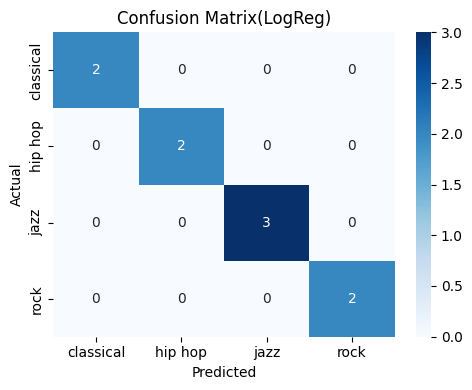

Saved scaler.joblib and model_LogReg.joblib


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
# Load features
df=pd.read_csv('features.csv')
X=df.drop(columns=['label']).values
y=df['label'].values
# Train/test split (stratified)
Xtr, Xte, ytr,yte = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)
#Scale
scaler = StandardScaler().fit(Xtr)
Xtr_s = scaler.transform(Xtr)
Xte_s = scaler.transform(Xte)
models = {
    'LogReg':LogisticRegression(max_iter=1000),
    'LinearSVM':LinearSVC(),
    'RandomForest':RandomForestClassifier(n_estimators=300,random_state=42)
}
best_name, best_model, best_f1=None, None, -1
for name, clf in models.items():
  clf.fit(Xtr_s, ytr)
  pred=clf.predict(Xte_s)
  acc=accuracy_score(yte, pred)
  f1=f1_score(yte, pred, average='macro')
  print(f"{name}: Accuracy={acc:.3f}, Macro-F1={f1:.3f}")
  if f1>best_f1:
    best_name, best_model, best_f1=name, clf, f1

print("\nBest model:",best_name)
#Evaluate
pred=best_model.predict(Xte_s)
print("\nClassification Report:\n",classification_report(yte, pred))
cm=confusion_matrix(yte, pred, labels=np.unique(y))
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title(f'Confusion Matrix({best_name})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()
#Save
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(best_model, f'model_{best_name}.joblib')
print("Saved scaler.joblib and", f"model_{best_name}.joblib")